In [71]:
import os, re
import spacy
import pickle
import string
import gensim
import numpy as np
import pandas as pd
import seaborn as sns
import pyLDAvis.gensim
import multiprocessing as mp
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from pyLDAvis import sklearn as sklearn_lda
from nltk.stem import SnowballStemmer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation as LDA

# Folder
folder = './training/Final/'
file =  folder + 'dataset.csv'

# Init
nlp = spacy.load("en_core_web_sm")
stemmer = SnowballStemmer('english',ignore_stopwords=True)
punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%"]
extra = ['datum','siem','®']
STOPLIST = ENGLISH_STOP_WORDS.union(punc)
STOPLIST = STOPLIST.union(extra)
SYMBOLS = "?:!.,;(){}|[]%'+*\"


# Viz Init
sns.set_style('whitegrid')
%matplotlib inline

In [72]:
frame = pd.read_csv(file, sep='|')
frame.head()

,content,industries,location,title,type_empl,url,wage,suburb,experiences,title_left_over
0,Queensland Audit Office Investing in analytics...,Information & Communication Technology,Brisbane,DA,Permanent,https://www.seek.com.au/job/38867796?type=prom...,115000.0,CBD & Inner Suburbs,General,Analyst - Audit Analytics
1,Working for this market leader within the Fina...,Information & Communication Technology,Brisbane,DA,Permanent,https://www.seek.com.au/job/38986499?type=stan...,115000.0,CBD & Inner Suburbs,General,Head of Data Analytics & Performance
2,Queensland Audit Office Investing in analytics...,Information & Communication Technology,Brisbane,DA,Permanent,https://www.seek.com.au/job/39008462?type=stan...,115000.0,CBD & Inner Suburbs,General,Analyst - Audit Analytics
3,New Data Analyst opportunity with a well-known...,Information & Communication Technology,Brisbane,DA,Contract,https://www.seek.com.au/job/38942920?type=stan...,115000.0,CBD & Inner Suburbs,General,Data Analyst
4,Information Technology Services The Division o...,Information & Communication Technology,Brisbane,SDA,Permanent,https://www.seek.com.au/job/39005084?type=stan...,144000.0,Brisbane,Senior,Senior Business Analyst / Data Modeller


In [73]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1569 entries, 0 to 1568
Data columns (total 10 columns):
content            1569 non-null object
industries         1569 non-null object
location           1569 non-null object
title              1569 non-null object
type_empl          1569 non-null object
url                1569 non-null object
wage               1569 non-null float64
suburb             1569 non-null object
experiences        1569 non-null object
title_left_over    1569 non-null object
dtypes: float64(1), object(9)
memory usage: 122.7+ KB


In [77]:
# Remove website or any urls
frame['content'] = frame['content'].map(lambda row: re.sub(r"(((http|https):\/\/)?www[a-z\.\/-]+)","website",row))

# Remove Punctuation
frame['content'] = frame['content'].map(lambda row: re.sub(r"[(,\.!?;:)]","",row))

# To Lower
frame['content'] = frame['content'].map(lambda row: row.lower())

In [78]:
def tokenizeText(sample):
    tokens = nlp(sample)
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas
    tokens = [re.sub(r"([0-9]+)","",tok) for tok in tokens]
    tokens = [tok for tok in tokens if tok not in STOPLIST]
    tokens = [tok for tok in tokens if tok not in SYMBOLS]
    return tokens

class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self,
                 variety="BrE",
                 user_abbrevs={},
                 n_jobs=1):
        """
        Text preprocessing transformer includes steps:
            1. Text normalization
            2. Punctuation removal
            3. Stop words removal
            4. Lemmatization
        
        variety - format of date (AmE - american type, BrE - british format) 
        user_abbrevs - dict of user abbreviations mappings (from normalise package)
        n_jobs - parallel jobs to run
        """
        self.variety = variety
        self.user_abbrevs = user_abbrevs
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        return self

    def transform(self, X, *_):
        X_copy = X.copy()

        partitions = 1
        cores = mp.cpu_count()
        if self.n_jobs <= -1:
            partitions = cores
        elif self.n_jobs <= 0:
            return X_copy.apply(self._preprocess_text)
        else:
            partitions = min(self.n_jobs, cores)

        data_split = np.array_split(X_copy, partitions)
        pool = mp.Pool(cores)
        data = pd.concat(pool.map(self._preprocess_part, data_split))
        pool.close()
        pool.join()

        return data

    def _preprocess_part(self, part):
        return part.apply(self._preprocess_text)

    def _preprocess_text(self, text):
        normalized_text = self._normalize(text)
        doc = nlp(normalized_text)
        removed_punct = self._remove_punct(doc)
        removed_stop_words = self._remove_stop_words(removed_punct)
        return self._lemmatize(removed_stop_words)

    def _normalize(self, text):
        # some issues in normalise package
        try:
            return ' '.join(normalise(text, variety=self.variety, user_abbrevs=self.user_abbrevs, verbose=False))
        except:
            return text

    def _remove_punct(self, doc):
        return [t for t in doc if t.text not in string.punctuation]

    def _remove_stop_words(self, doc):
        return [t for t in doc if not t.is_stop]

    def _lemmatize(self, doc):
        return ' '.join([t.lemma_ for t in doc])

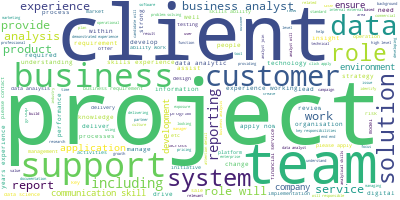

In [79]:
# Join the different processed title together.
long_string = ','.join(list(frame['content'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [80]:
# %%time
tp = TextPreprocessor(n_jobs=-1).fit(frame['content'])
new_content = tp.transform(frame['content'])

In [81]:
type(new_content)

pandas.core.series.Series

In [82]:
frame['new_content'] = new_content
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1569 entries, 0 to 1568
Data columns (total 11 columns):
content            1569 non-null object
industries         1569 non-null object
location           1569 non-null object
title              1569 non-null object
type_empl          1569 non-null object
url                1569 non-null object
wage               1569 non-null float64
suburb             1569 non-null object
experiences        1569 non-null object
title_left_over    1569 non-null object
new_content        1569 non-null object
dtypes: float64(1), object(10)
memory usage: 134.9+ KB


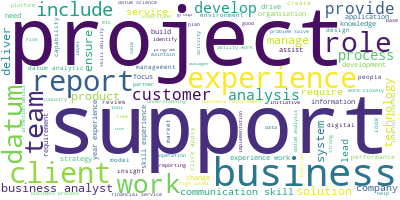

In [83]:
# Join the different processed title together.
long_string = ','.join(list(frame['new_content'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [84]:
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
    
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

/home/shayne/Anaconda3/envs/caps_env/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


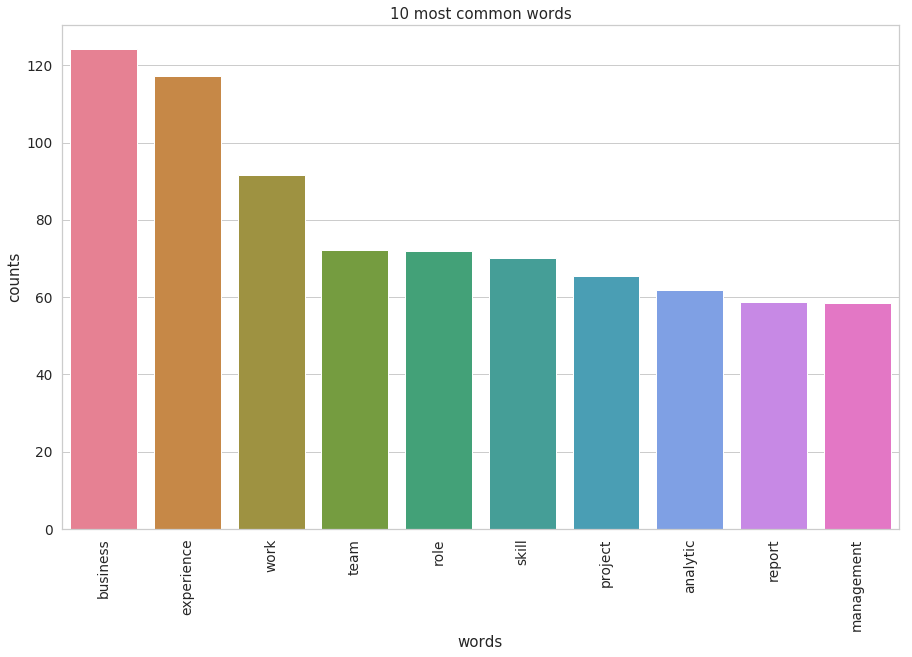

In [85]:
# Initialise the count vectorizer with the English stop words
vectorizer3 = TfidfVectorizer(stop_words=STOPLIST,tokenizer=tokenizeText,use_idf=True, max_features=2000)

# Fit and transform the contexts
count_data_2 = vectorizer3.fit_transform(frame['new_content'])

# Visualise the 10 most common words
plot_10_most_common_words(count_data_2, vectorizer3)

In [86]:
word_features3 = vectorizer3.get_feature_names()
len(word_features3)

2000

In [96]:
word_features3

["'s",
 '+',
 '-month',
 '-pron-',
 '/',
 '//',
 ':pm',
 'ability',
 'able',
 'aboriginal',
 'abreast',
 'academic',
 'accelerate',
 'accept',
 'acceptance',
 'access',
 'accessibility',
 'accessible',
 'accord',
 'accordance',
 'accordingly',
 'account',
 'accountability',
 'accountable',
 'accountant',
 'accounting',
 'accuracy',
 'accurate',
 'accurately',
 'achieve',
 'achievement',
 'acquire',
 'acquisition',
 'act',
 'action',
 'actionable',
 'active',
 'actively',
 'activity',
 'actuarial',
 'actuary',
 'acuman',
 'ad',
 'adapt',
 'add',
 'addition',
 'additional',
 'additionally',
 'address',
 'adhere',
 'adherence',
 'adhoc',
 'adjustment',
 'administer',
 'administration',
 'administrative',
 'administrator',
 'adobe',
 'adopt',
 'adoption',
 'advance',
 'advanced',
 'advantage',
 'advantageous',
 'advertise',
 'advertisement',
 'advertising',
 'advice',
 'advise',
 'advisor',
 'advisory',
 'advocate',
 'affect',
 'afp',
 'afraid',
 'age',
 'agency',
 'agile',
 'agility',
 'a

In [87]:
# Tweak the two parameters below
number_topics = 10
number_words = 12

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(count_data_2)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, vectorizer3, number_words)

Topics found via LDA:

Topic #0:
trading asic trader trade hub connectivity cx servicenow jone c++ fix electronic

Topic #1:
· tm forensic cogno feed concur overseas upgrade advertisement sunday star heavily

Topic #2:
campaign marketing adobe tag treasury google edm auto reinsurance uncover channel brief

Topic #3:
business experience work project skill role requirement process team client solution management

Topic #4:
afp qbe energyaustralia advertisement criminal electric schneider cybersecurity police enforcement reinsurance commonwealth

Topic #5:
cutover council gis sunday :pm officer land auto reconciliation mobility true devise

Topic #6:
train tax kyc institutional rail nsw crew holland john tfnsw mar sydney

Topic #7:
marketing campaign report team insight sale work customer business financial role performance

Topic #8:
analytic audit science foxtel queensland qao entertainment emerge machine scientist technique sport

Topic #9:
laboratory sample op routine organic food com

In [93]:
processed_docs = lda.transform(count_data_2)
print(len(processed_docs))
print(len(processed_docs[0]))


1569
10


In [98]:
dframe = pd.DataFrame(processed_docs)
dframe.head(10)

,0,1,2,3,4,5,6,7,8,9
0,0.008940,0.008940,0.008940,0.008945,0.008940,0.008940,0.008940,0.008943,0.919533,0.008940
1,0.007251,0.007251,0.007251,0.922988,0.007252,0.007251,0.007251,0.019003,0.007252,0.007251
2,0.008561,0.008561,0.008561,0.008564,0.008561,0.008561,0.008561,0.008563,0.922949,0.008561
3,0.011048,0.011048,0.011048,0.900565,0.011048,0.011048,0.011048,0.011050,0.011049,0.011048
4,0.010042,0.010042,0.010042,0.828620,0.010042,0.010042,0.010042,0.010046,0.091039,0.010042
5,0.011407,0.011407,0.011407,0.897330,0.011407,0.011407,0.011407,0.011412,0.011411,0.011407
6,0.008421,0.008421,0.008424,0.735572,0.008421,0.008421,0.008421,0.197055,0.008425,0.008421
7,0.010836,0.010836,0.010836,0.880141,0.010836,0.010836,0.010836,0.033174,0.010836,0.010836
8,0.013594,0.013594,0.013600,0.353319,0.013594,0.013594,0.013594,0.537919,0.013596,0.013594
9,0.010990,0.010990,0.010990,0.877968,0.010990,0.010990,0.010990,0.034109,0.010991,0.010990


In [67]:
# Push to dictionary
dictionary = gensim.corpora.Dictionary(processed_docs)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xbd in position 1: invalid start byte

In [44]:
LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics))
print(LDAvis_data_filepath)

./ldavis_prepared_10


In [45]:
count_data_2

<1569x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 205450 stored elements in Compressed Sparse Row format>

In [43]:
# LDA help vizualize
lda_display = pyLDAvis.gensim.prepare(lda, count_data_2, vectorizer3)
pyLDAvis.display(lda_display)

AttributeError: 'TfidfVectorizer' object has no attribute 'token2id'

In [47]:
%%time

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = sklearn_lda.prepare(lda, count_data_2, vectorizer3)
    with open(LDAvis_data_filepath, 'w') as f:
        pickle.dump(LDAvis_prepared, f)

    # load the pre-prepared pyLDAvis data from disk
    with open(LDAvis_data_filepath) as f:
        LDAvis_prepared = pickle.load(f)
    pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')

/home/shayne/Anaconda3/envs/caps_env/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


TypeError: write() argument must be str, not bytes